# Introducing Keras

Let's use Keras on the MNIST data set again, this time using a Convolutional Neural Network that's better suited for image processing. CNN's are less sensitive to where in the image the pattern is that we're looking for.

With a multi-layer perceptron, we achieved around 97% accuracy. Let's see if we can beat that.

As before we'll start by importing the stuff we need, including the new layer types we talked about:

In [1]:
import tensorflow
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import RMSprop

We'll load up our raw data set exactly as before:

In [2]:
(mnist_train_images, mnist_train_labels), (mnist_test_images, mnist_test_labels) = mnist.load_data()

We need to shape the data differently then before. Since we're treating the data as 2D images of 28x28 pixels instead of a flattened stream of 784 pixels, we need to shape it accordingly. Depending on the data format Keras is set up for, this may be 1x28x28 or 28x28x1 (the "1" indicates a single color channel, as this is just grayscale. If we were dealing with color images, it would be 3 instead of 1 since we'd have red, green, and blue color channels)

In [4]:
from tensorflow.keras import backend as K

if K.image_data_format() == 'channels_first':
    train_images = mnist_train_images.reshape(mnist_train_images.shape[0], 1, 28, 28)
    test_images = mnist_test_images.reshape(mnist_test_images.shape[0], 1, 28, 28)
    input_shape = (1, 28, 28)
else:
    train_images = mnist_train_images.reshape(mnist_train_images.shape[0], 28, 28, 1)
    test_images = mnist_test_images.reshape(mnist_test_images.shape[0], 28, 28, 1)
    input_shape = (28, 28, 1)
    
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
train_images /= 255
test_images /= 255

As before we need to convert our train and test labels to be categorical in one-hot format:

In [5]:
train_labels = tensorflow.keras.utils.to_categorical(mnist_train_labels, 10)
test_labels = tensorflow.keras.utils.to_categorical(mnist_test_labels, 10)

As a sanity check let's print out one of the training images with its label:

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


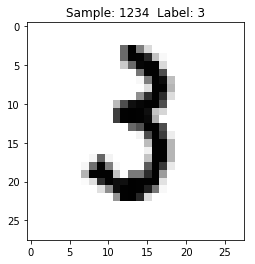

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt

def display_sample(num):
    #Print the one-hot array of this sample's label 
    print(train_labels[num])  
    #Print the label converted back to a number
    label = train_labels[num].argmax(axis=0)
    #Reshape the 768 values to a 28x28 image
    image = train_images[num].reshape([28,28])
    plt.title('Sample: %d  Label: %d' % (num, label))
    plt.imshow(image, cmap=plt.get_cmap('gray_r'))
    plt.show()
    
display_sample(1234)

Now for the meat of the problem. Setting up a convolutional neural network involves more layers. Not all of these are strictly necessary; you could run without pooling and dropout, but those extra steps help avoid overfitting and help things run faster.

We'll start with a 2D convolution of the image - it's set up to take 32 windows, or "filters", of each image, each filter being 3x3 in size.

We then run a second convolution on top of that with 64 3x3 windows - this topology is just what comes recommended within Keras's own examples. Again you want to re-use previous research whenever possible while tuning CNN's, as it is hard to do.

Next we apply a MaxPooling2D layer that takes the maximum of each 2x2 result to distill the results down into something more manageable.

A dropout filter is then applied to prevent overfitting.

Next we flatten the 2D layer we have at this stage into a 1D layer. So at this point we can just pretend we have a traditional multi-layer perceptron...

... and feed that into a hidden, flat layer of 128 units.

We then apply dropout again to further prevent overfitting.

And finally, we feed that into our final 10 units where softmax is applied to choose our category of 0-9.

In [7]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
# 64 3x3 kernels
model.add(Conv2D(64, (3, 3), activation='relu'))
# Reduce by taking the max of each 2x2 block
model.add(MaxPooling2D(pool_size=(2, 2)))
# Dropout to avoid overfitting
model.add(Dropout(0.25))
# Flatten the results to one dimension for passing into our final layer
model.add(Flatten())
# A hidden layer to learn with
model.add(Dense(128, activation='relu'))
# Another dropout
model.add(Dropout(0.5))
# Final categorization from 0-9 with softmax
model.add(Dense(10, activation='softmax'))

Let's double check the model description:

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
__________

We are still doing multiple categorization, so categorical_crossentropy is still the right loss function to use. We'll use the Adam optimizer, although the example provided with Keras uses RMSProp. You might want to try both if you have time.

In [9]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

And now we train our model... to make things go a little faster, we'll use batches of 32.

## Warning

This could take hours to run, and your computer's CPU will be maxed out during that time! Don't run the next block unless you can tie up your computer for a long time. It will print progress as each epoch is run, but each epoch can take around 20 minutes.

In [10]:
history = model.fit(train_images, train_labels,
                    batch_size=32,
                    epochs=10,
                    verbose=2,
                    validation_data=(test_images, test_labels))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 1038s - loss: 0.1937 - acc: 0.9417 - val_loss: 0.0491 - val_acc: 0.9838
Epoch 2/10
 - 1025s - loss: 0.0815 - acc: 0.9756 - val_loss: 0.0396 - val_acc: 0.9882
Epoch 3/10
 - 1041s - loss: 0.0630 - acc: 0.9807 - val_loss: 0.0329 - val_acc: 0.9888
Epoch 4/10
 - 1048s - loss: 0.0502 - acc: 0.9839 - val_loss: 0.0282 - val_acc: 0.9908
Epoch 5/10
 - 1044s - loss: 0.0417 - acc: 0.9869 - val_loss: 0.0328 - val_acc: 0.9895
Epoch 6/10
 - 1042s - loss: 0.0360 - acc: 0.9892 - val_loss: 0.0283 - val_acc: 0.9906
Epoch 7/10
 - 1039s - loss: 0.0309 - acc: 0.9904 - val_loss: 0.0297 - val_acc: 0.9913
Epoch 8/10
 - 1029s - loss: 0.0292 - acc: 0.9903 - val_loss: 0.0283 - val_acc: 0.9913
Epoch 9/10
 - 1018s - loss: 0.0264 - acc: 0.9916 - val_loss: 0.0306 - val_acc: 0.9911
Epoch 10/10
 - 1009s - loss: 0.0223 - acc: 0.9929 - val_loss: 0.0334 - val_acc: 0.9913


Was it worth the wait?

In [11]:
score = model.evaluate(test_images, test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.03337819409219155
Test accuracy: 0.9913


Over 99%! And that's with just 10 epochs! It came at a significant cost in terms of computing power, but when you start distributing things over multiple computers each with multiple GPU's, that cost starts to feel less bad. If you're building something where life and death are on the line, like a self-driving car, every fraction of a percent matters.